In [47]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import mlflow
import mlflow.sklearn

In [48]:
os.environ['OMP_NUM_THREADS'] = '1'


In [2]:
df = pd.read_csv("Mall_Customers.csv")

In [3]:
# Display the first 5 rows of the dataset
print(df.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


# Preprocessing Data

In [4]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### Encoding Categorical Vaiables

In [5]:
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})

### Standardizing the data

In [6]:
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)", "Gender" ]

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

In [8]:
scaled_data = pd.DataFrame(scaled_data, columns= features)

In [9]:
scaled_data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,-1.128152
1,-1.281035,-1.738999,1.195704,-1.128152
2,-1.352802,-1.700830,-1.715913,0.886405
3,-1.137502,-1.700830,1.040418,0.886405
4,-0.563369,-1.662660,-0.395980,0.886405


Data visualization to help understand the distribution and relationship between different features.

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

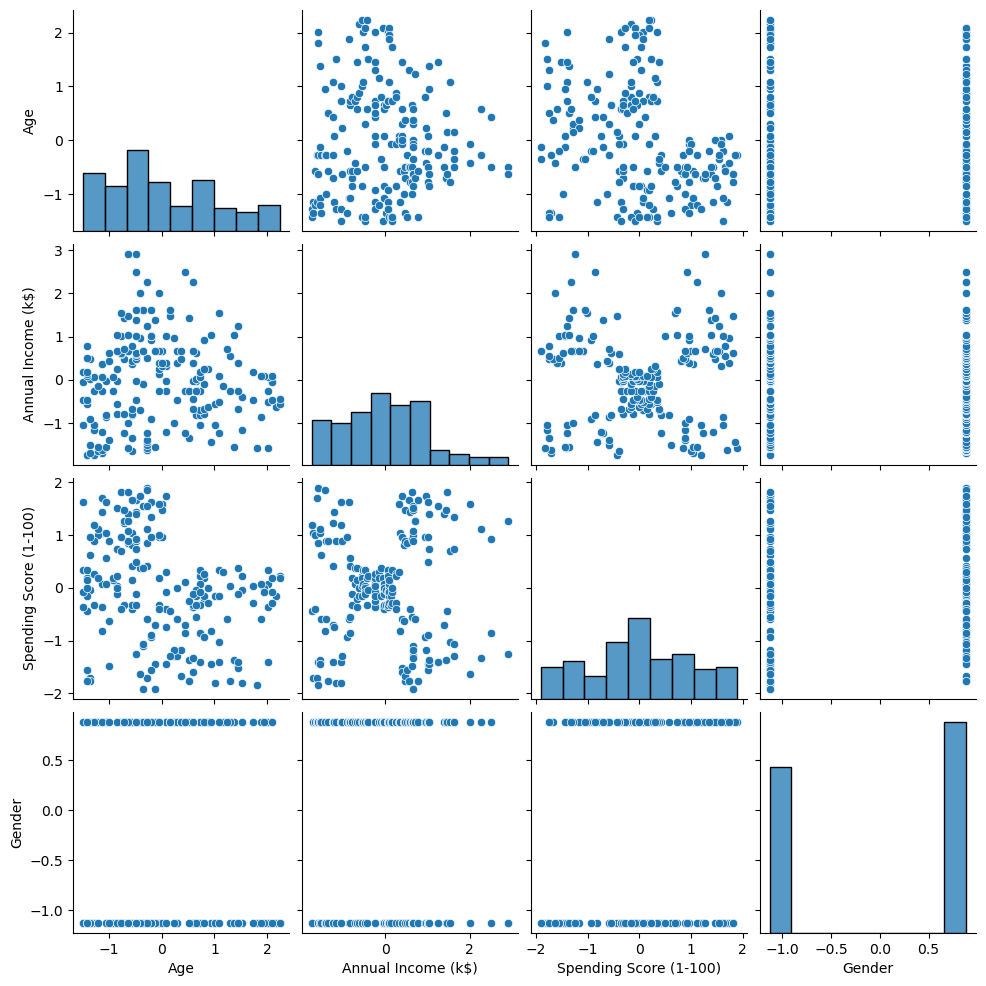

In [10]:
sns.pairplot(scaled_data)
plt.show()



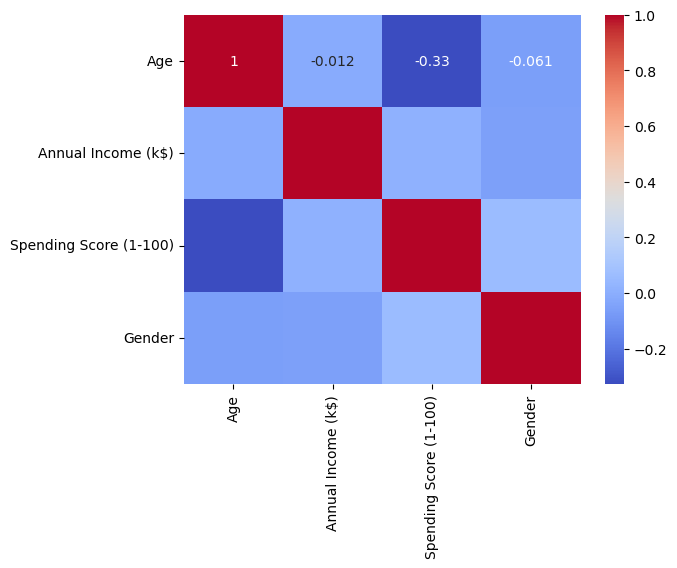

In [11]:
# Visualize the correlation matrix
correlation_matrix = scaled_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [16]:
pca = PCA(n_components= 2) # crating PCA object

pca_data = pca.fit_transform(scaled_data)

pca_data_df = pd.DataFrame(pca_data, columns = ["PCA1", "PCA2"]) # reducing the data to 2-dimensions

In [17]:
pca_data_df

,PCA1,PCA2
0,-0.406383,-0.520714
1,-1.427673,-0.367310
2,0.050761,-1.894068
3,-1.694513,-1.631908
4,-0.313108,-1.810483
...,...,...
195,-1.179572,1.324568
196,0.672751,1.221061
197,-0.723719,2.765010
198,0.767096,2.861930


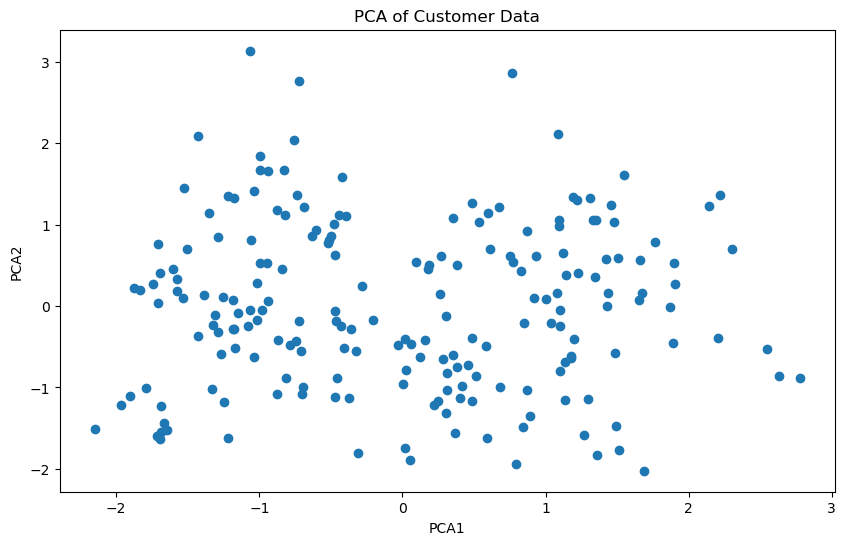

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_data_df['PCA1'], pca_data_df['PCA2'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Customer Data')
plt.show()

# K-Means Clustering

In [50]:
mlflow.set_experiment("Customer Segmentation")

with mlflow.start_run():
    kmeans =KMeans(n_clusters = 5, random_state = 42, n_init = "auto")
    kmeans.fit(scaled_data)

    # Predict cluster labels
    cluster_labels = kmeans.predict(scaled_data)
    
    # Calculate evaluation metrics
    silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, cluster_labels))
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    davies_bouldin_avg = davies_bouldin_score(scaled_data, cluster_labels)

    # logging parameters and metrics
    mlflow.log_param("n_clusters", 5)
    mlflow.log_metric("inertia", kmeans.inertia_)
    mlflow.log_metric("silhouette_score", silhouette_avg)
    mlflow.log_metric("davies_bouldin_score", davies_bouldin_avg)
    

    # Log the model
    mlflow.sklearn.log_model(kmeans, "kmeans_model")

     # Add cluster labels to the original data

    df["Cluster"] = kmeans.labels_

c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

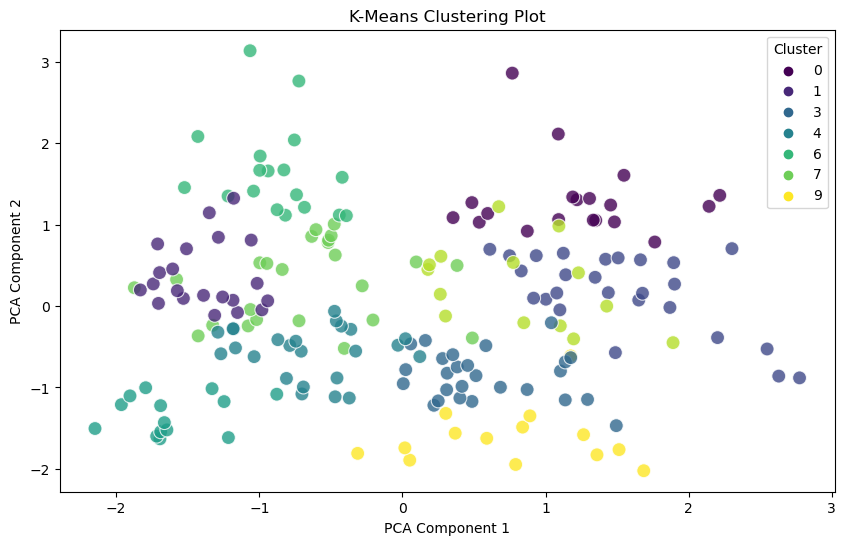

In [51]:
# Plot clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data_df['PCA1'], y=pca_data_df['PCA2'], hue=df['Cluster'], palette='viridis', s=100, alpha=0.8, edgecolor='w')
plt.title('K-Means Clustering Plot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [52]:
# Display cluster centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
print("Cluster Centroids:")
print(centroids_df)

Cluster Centroids:
         Age  Annual Income (k$)  Spending Score (1-100)    Gender
0  38.473684           85.894737               14.210526  0.000000
1  32.190476           86.047619               81.666667  1.000000
2  58.846154           48.692308               39.846154  0.000000
3  54.153846           54.230769               48.961538  1.000000
4  27.833333           58.125000               46.541667  1.000000
5  25.857143           26.642857               79.142857  1.000000
6  33.277778           87.111111               82.666667  0.000000
7  25.250000           41.250000               60.916667  0.000000
8  43.785714           93.285714               20.642857  1.000000
9  41.214286           26.071429               20.142857  0.928571


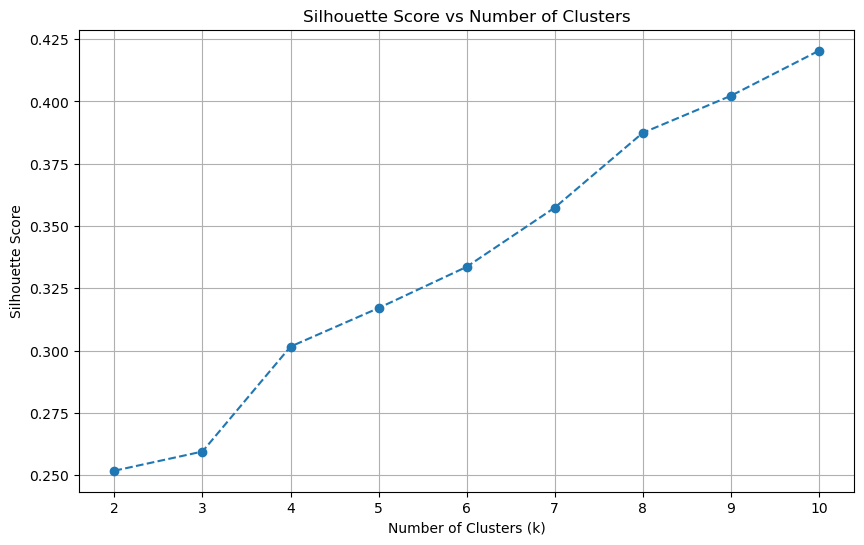

In [53]:
# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     cluster_labels = kmeans.fit_predict(scaled_data)
#     silhouette_scores.append(silhouette_score(scaled_data, cluster_labels))

# Plotting silhouette scores to determine optimal k
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()